<a href="https://colab.research.google.com/github/andres-merino/AprendizajeAutomaticoInicial-05-N0105/blob/main/2-Ejercicios/03-Agrupamiento-Jerarquico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table style="border: none; border-collapse: collapse;">
    <tr>
        <td style="width: 20%; vertical-align: middle; padding-right: 10px;">
            <img src="https://i.imgur.com/nt7hloA.png" width="100">
        </td>
        <td style="width: 2px; text-align: center;">
            <font color="#0030A1" size="7">|</font><br>
            <font color="#0030A1" size="7">|</font>
        </td>
        <td>
            <p style="font-variant: small-caps;"><font color="#0030A1" size="5">
                <b>Escuela de Ciencias Físicas y Matemática</b>
            </font> </p>
            <p style="font-variant: small-caps;"><font color="#0030A1" size="4">
                Aprendizaje Automático Inicial &bull; Agrupamiento Jerarquico
            </font></p>
            <p style="font-style: oblique;"><font color="#0030A1" size="3">
                Andrés Merino &bull; 2024-02
            </font></p>
        </td>  
    </tr>
</table>

---
## <font color='264CC7'> Introducción </font>

A lo largo de este taller, aplicaremos el algoritmo de agrupamiento jerárquico a un conjunto de datos.

Los paquetes necesarios son:

In [1]:
# Paquetes necesarios
import pandas as pd # Para manejo de datos
import matplotlib.pyplot as plt # Para visualización
import numpy as np # Para manejo de arreglos
import plotly.express as px # Para visualización
from scipy.spatial.distance import cdist # Para cálculo de distancias
# Modelo de clustering jerárquico
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
# Estandarización de datos
from sklearn.preprocessing import StandardScaler
# Para PCA
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score


---
## <font color='264CC7'> Preprocesamiento de datos </font>

Primero necesitas el conjunto de datos. Los datos a utilzar son los seleccionados en la clase aterior.

<div style="background-color: #edf1f8; border-color: #264CC7; border-left: 5px solid #264CC7; padding: 0.5em;">
<strong>Ejercicio:</strong><br>
    Carga el conjunto de datos y procésalos:
<ul>
  <li>Muestra algunos datos.</li>
  <li>Muestra una descripción de los datos.</li>
  <li>Escala los datos si es necesario.</li>
</ul>
</div>

**Carga de datos**

In [2]:
# Leer los datos
data = pd.read_csv('https://raw.githubusercontent.com/mnloor/Aprendizaje-Automatico/refs/heads/main/Datos/1-%20mental-illnesses-prevalence.csv')

data.rename(columns={
    'Entity': 'País',
    'Code': 'Código',
    'Year': 'Anio',
    'Schizophrenia disorders (share of population) - Sex: Both - Age: Age-standardized': 'Esquizofrenia',
    'Depressive disorders (share of population) - Sex: Both - Age: Age-standardized': 'Depresión',
    'Anxiety disorders (share of population) - Sex: Both - Age: Age-standardized': 'Ansiedad',
    'Bipolar disorders (share of population) - Sex: Both - Age: Age-standardized': 'Trastorno Bipolar',
    'Eating disorders (share of population) - Sex: Both - Age: Age-standardized': 'Trastorno Alimenticio'
}, inplace=True)

# Verificar nombres de columnas
data.columns

data = data[data['Anio'] == 2011]

# Tomo las columnas de interés
numeric_cols = ['Esquizofrenia', 'Depresión', 'Ansiedad', 'Trastorno Bipolar', 'Trastorno Alimenticio']
data = data[['País', *numeric_cols]]

# Muestro los primeros registros
display(data.head())

,País,Esquizofrenia,Depresión,Ansiedad,Trastorno Bipolar,Trastorno Alimenticio
21,Afghanistan,0.216218,4.945379,4.715658,0.699392,0.107169
51,Africa (IHME GBD),0.219953,4.488090,3.689709,0.604527,0.115847
81,Albania,0.285579,2.441195,3.767038,0.542330,0.124728
111,Algeria,0.248350,4.051072,4.670081,0.756370,0.201481
141,America (IHME GBD),0.342383,3.664557,5.665880,0.840436,0.304766


**Descripción de los datos**

In [3]:
data.describe()

,Esquizofrenia,Depresión,Ansiedad,Trastorno Bipolar,Trastorno Alimenticio
count,214.000000,214.000000,214.000000,214.000000,214.000000
mean,0.267354,3.713053,4.127244,0.637699,0.204274
std,0.039896,0.930430,1.083103,0.234761,0.146004
min,0.188597,1.525051,1.882687,0.182025,0.044780
25%,0.241687,3.009873,3.436885,0.520765,0.099475
50%,0.273864,3.575002,3.977787,0.578972,0.148526
75%,0.286799,4.358166,4.547295,0.843415,0.265535
max,0.458543,6.931850,8.370385,1.506619,0.997994


**Escalar los datos**

In [4]:
# Escalar los datos
scaler = StandardScaler()
X = scaler.fit_transform(data.iloc[:, 1:])

---
## <font color='264CC7'> Dendograma </font>

<div style="background-color: #edf1f8; border-color: #264CC7; border-left: 5px solid #264CC7; padding: 0.5em;">
<strong>Ejercicio:</strong><br>
    Genera el dendograma de los datos.
<ul>
  <li>Usa diferentes métricas y funciones de enlace.</li>
  <li>Toma una distancia de corte.</li>
  <li>De manera intutiva, ¿por qué tomaste la métrica y la distancia de corte?</li>
</ul>
</div>

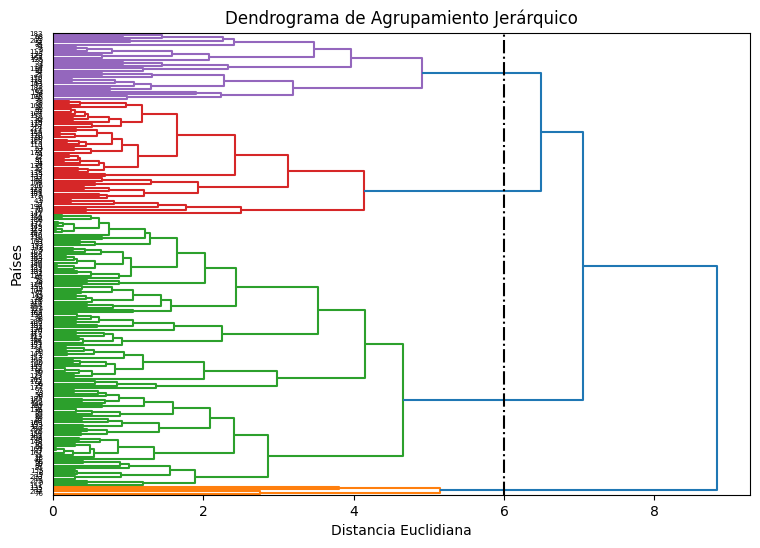

In [7]:
# Realizamos el clustering jerárquico
Z = linkage(X, method='complete',metric='euclidean')

# Definir la distancia de corte
distancia_corte = 6

# Calcular el dendrograma
plt.figure(figsize=(9, 6))
dendrogram(Z,
    orientation='right', )
plt.axvline(x=distancia_corte, c='k', ls='dashdot')
plt.title("Dendrograma de Agrupamiento Jerárquico")
plt.xlabel("Distancia Euclidiana")
plt.ylabel("Países")
plt.show()

* Elegí usar el método de enlace complete con distancia euclidiana porque se enfoca en crear clústeres compactos y claramente separados al usar la distancia máxima entre puntos de diferentes grupos. La distancia euclidiana es la indicada porque mide diferencias en un espacio continuo, lo que se ajusta bien a variables ya están estandarizadas.

* El punto de corte lo elegí porque considero que en ese punto se puede ver una distancia significativa para crear esos nuevos clusters, a partir de los anteriores. Además mi objetivo es agrupar países de acuerdo a transtornos mentales de las personas.


---
## <font color='264CC7'> Asignación de grupos y análisis </font>


<div style="background-color: #edf1f8; border-color: #264CC7; border-left: 5px solid #264CC7; padding: 0.5em;">
<strong>Ejercicio:</strong><br>
    Realiza un análisis de los grupos obtenidos.
<ul>
  <li>Asigna los grupos.</li>
  <li>Revisa la media de cada grupo.</li>
  <li>Revisa el mínimo y máximo de cada grupo.</li>
  <li>Muestra algunos integrantes de cada grupo.</li>
</ul>
</div>

**Asignación de grupos**

In [8]:
# Ahora asignamos las etiquetas de clúster
clusters = fcluster(Z, t=distancia_corte, criterion='distance')

# Agregar la información de clúster como C1, C2, C3, etc.
data['Cluster'] = ['C' + str(c) for c in clusters]

# Revisar los primeros registros
display(data.head())

,País,Esquizofrenia,Depresión,Ansiedad,Trastorno Bipolar,Trastorno Alimenticio,Cluster
21,Afghanistan,0.216218,4.945379,4.715658,0.699392,0.107169,C3
51,Africa (IHME GBD),0.219953,4.488090,3.689709,0.604527,0.115847,C3
81,Albania,0.285579,2.441195,3.767038,0.542330,0.124728,C2
111,Algeria,0.248350,4.051072,4.670081,0.756370,0.201481,C2
141,America (IHME GBD),0.342383,3.664557,5.665880,0.840436,0.304766,C4


**Elementos por clústers**

In [9]:
# Cantidades de elementos por clúster
data['Cluster'].value_counts()

,count
Cluster,
C2,126
C3,53
C4,31
C1,4


**Media de cada grupo**

In [10]:
# Podemos ver las medias de cada clúster
data.groupby('Cluster')[numeric_cols].mean()

,Esquizofrenia,Depresión,Ansiedad,Trastorno Bipolar,Trastorno Alimenticio
Cluster,,,,,
C1,0.404909,4.742469,5.835407,0.970645,0.626570
C2,0.278235,3.160603,3.793974,0.577350,0.175688
C3,0.220638,4.858010,3.773283,0.597595,0.116235
C4,0.285251,3.868164,5.866574,0.908595,0.416490


**Mínimo y máximo de cada grupo**

In [11]:
# Mínimo y máximo de cada grupo
display(data.groupby('Cluster')[numeric_cols].agg(['min', 'max']))

Esquizofrenia           Depresión            Ansiedad            \
                  min       max       min       max       min       max   
Cluster                                                                   
C1           0.383113  0.458543  3.652685  6.160037  4.790210  7.255383   
C2           0.200450  0.328624  1.525051  4.161697  1.882687  5.498894   
C3           0.188597  0.277339  4.046925  6.931850  2.870956  5.502382   
C4           0.240981  0.381396  2.969386  5.463120  3.819379  8.370385   

        Trastorno Bipolar           Trastorno Alimenticio            
                      min       max                   min       max  
Cluster                                                              
C1               0.602031  1.506619              0.455493  0.997994  
C2               0.182025  1.039076              0.064245  0.432644  
C3               0.384410  0.896800              0.044780  0.273384  
C4               0.700732  1.112178              0.204545  0.801716

**Algunos integrantes por cada grupo**

In [12]:
for cluster in data['Cluster'].unique():
    print(f'Cluster {cluster}: cantidad de elementos {data[data["Cluster"] == cluster].shape[0]}')
    display(data[data['Cluster'] == cluster].head(5))

Cluster C3: cantidad de elementos 53


,País,Esquizofrenia,Depresión,Ansiedad,Trastorno Bipolar,Trastorno Alimenticio,Cluster
21,Afghanistan,0.216218,4.945379,4.715658,0.699392,0.107169,C3
51,Africa (IHME GBD),0.219953,4.488090,3.689709,0.604527,0.115847,C3
231,Angola,0.216881,5.749008,3.978852,0.553895,0.125789,C3
501,Bahrain,0.271523,4.614372,4.920335,0.776609,0.273384,C3
531,Bangladesh,0.277339,4.572979,3.141756,0.389732,0.099782,C3


Cluster C2: cantidad de elementos 126


,País,Esquizofrenia,Depresión,Ansiedad,Trastorno Bipolar,Trastorno Alimenticio,Cluster
81,Albania,0.285579,2.441195,3.767038,0.542330,0.124728,C2
111,Algeria,0.248350,4.051072,4.670081,0.756370,0.201481,C2
171,American Samoa,0.307144,2.616261,3.999533,0.279724,0.128153,C2
261,Antigua and Barbuda,0.287932,2.849617,4.303295,0.946242,0.269954,C2
291,Argentina,0.312662,2.414126,4.897788,1.039076,0.318238,C2


Cluster C4: cantidad de elementos 31


,País,Esquizofrenia,Depresión,Ansiedad,Trastorno Bipolar,Trastorno Alimenticio,Cluster
141,America (IHME GBD),0.342383,3.664557,5.665880,0.840436,0.304766,C4
201,Andorra,0.287029,3.547046,5.412389,0.935904,0.520345,C4
411,Austria,0.275605,3.092570,5.919340,0.901901,0.555027,C4
771,Bolivia,0.264914,3.440799,5.667082,0.887325,0.215879,C4
861,Brazil,0.277096,3.928555,8.370385,1.112178,0.222514,C4


Cluster C1: cantidad de elementos 4


,País,Esquizofrenia,Depresión,Ansiedad,Trastorno Bipolar,Trastorno Alimenticio,Cluster
381,Australia,0.388511,4.661994,5.605869,1.125039,0.997994,C1
2301,Greenland,0.383113,6.160037,4.790210,0.648891,0.473920,C1
4071,New Zealand,0.389469,3.652685,7.255383,1.506619,0.578873,C1
6081,United States,0.458543,4.495158,5.690165,0.602031,0.455493,C1


<div style="background-color: #edf1f8; border-color: #264CC7; border-left: 5px solid #264CC7; padding: 0.5em;">
<strong>Ejercicio:</strong><br>
    Da una descripción de los grupos obtenidos. Asigna un nombre a cada grupo.
</div>

1. **Clúster C3: Países con trastornos mentales moderados**

* Descripción: Agrupa países con niveles moderados de esquizofrenia, depresión y ansiedad. Los trastornos bipolares y alimenticios son bajos, pero consistentemente presentes.
* Ejemplo: Afganistán, Angola, Bahréin, Bangladesh.

2. **Clúster C2: Países con ansiedad y bipolaridad**

* Descripción: Este grupo incluye países con niveles intermedios a altos de ansiedad y trastornos bipolares, junto con depresión moderada. Los trastornos alimenticios son más variados, pero suelen ser más altos que en otros grupos.
* Ejemplo: Albania, Argelia, Argentina, Samoa Americana.

3. **Clúster C4: Países con ansiedad alta y otros trastornos graves**

* Descripción: Agrupa países con los niveles más altos de ansiedad y trastornos alimenticios, junto con valores elevados de bipolaridad y depresión. Representa regiones con casos graves y concentrados.
* Ejemplo: Brasil, Bolivia, Estados Unidos, Austria.

4. **Clúster C1: Países con prevalencia alta**

* Descripción: Este es el clúster más pequeño, pero agrupa países con los valores más extremos en casi todas las categorías. Ansiedad, bipolaridad y trastornos alimenticios son especialmente altos.
* Ejemplo: Australia, Groenlandia, Nueva Zelanda, Estados Unidos.


---
## <font color='264CC7'> Visualizaciones  </font>

<div style="background-color: #edf1f8; border-color: #264CC7; border-left: 5px solid #264CC7; padding: 0.5em;">
<strong>Ejercicio:</strong><br>
    Realiza una visualización de los grupos obtenidos en 2D.
<ul>
  <li>¿Qué tan buenos te parecen los grupos?</li>
  <li>Indica el porcentaje de la variaza explicada en el gráfico, ¿afecta esto a tu visualización?</li>
</ul>
</div>

In [22]:
# Realizo un PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Crear un DataFrame para graficar fácilmente
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['País'] = data['País'].values
df_pca['Cluster'] = data['Cluster'].values

# Crear el scatterplot interactivo con Plotly Express
fig = px.scatter(
    df_pca,
    x='PC1',
    y='PC2',
    color='Cluster',
    hover_data=['País'],  # Mostrará 'País'
)

# Personalizar apariencia
fig.update_traces(marker=dict(opacity=0.8))
fig.update_layout(
    title='Clústeres visualizados en 2D (PCA)',
    width=800,
    height=600,
)

fig.show()

# Agregar información del porcentaje de varianza explicada
explained_variance_ratio = pca.explained_variance_ratio_
explained_variance_ratio_str

'Varianza explicada: 48.94% (CP1), 29.28% (CP2)'

* **¿Qué tan buenos te parecen los grupos**

En la visualización se puede observar una diferenciación entre los grupos, sin embargo no es tan clara como se esperaría, además no existe un buen  agrupamiento de los clústers, dado que los países aun se encuentran muy dispersos y existe superposición entre ellos en algunos clústers. Pero en general si se puede evidenciar los diferentes grupos entonces se puede decir que son medianamente buenos.

* **Indica el porcentaje de la variaza explicada en el gráfico, ¿afecta esto a tu visualización?**

El gráfico explica el 78.22% de la varianza total (48.94% en el primer componente y 29.28% en el segundo). Esto significa que gran parte de la información de los datos originales está representada en la visualización, lo que permite interpretar bien los clústeres. Sin embargo, todavía queda un 21.78% de la varianza no capturada, por lo que puede haber detalles o patrones adicionales.

---
## <font color='264CC7'> Métricas  </font>

<div style="background-color: #edf1f8; border-color: #264CC7; border-left: 5px solid #264CC7; padding: 0.5em;">
<strong>Ejercicio:</strong><br>
Calcula la métrica de la silueta para los grupos obtenidos. ¿Qué tan buenos te parecen los grupos?
</div>

In [19]:
from sklearn.metrics import silhouette_score

# Calcular la métrica de la silueta
silhouette_avg = silhouette_score(X, clusters)

print(f"El puntaje promedio de silueta es: {silhouette_avg}")

El puntaje promedio de silueta es: 0.29948907400898356


Con un puntaje promedio de silueta de 0.299, los grupos se consideran como  malos dado que el valor está más cercano a 0. Esto quiere decir que hay un poco de diferencias entre los países, pero estas diferencias no están suficientemente claras como para formar clústers bien definidos.

---
## <font color='264CC7'> Iteraciones </font>

<div style="background-color: #edf1f8; border-color: #264CC7; border-left: 5px solid #264CC7; padding: 0.5em;">
<strong>Ejercicio:</strong><br>
    Realiza el proceso de agrupamiento jerárquico con diferentes parámetros, analiza la métrica de la silueta de cada uno e indica cuál es el mejor.
</div>

In [21]:
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import silhouette_score
import numpy as np

methods_with_metrics = {
    'ward': ['euclidean'],  # Ward solo admite Euclidiana
    'complete': ['euclidean', 'cityblock', 'cosine'],  # Complete admite múltiples métricas
    'average': ['euclidean', 'cityblock', 'cosine'],  # Average admite múltiples métricas
    'single': ['euclidean', 'cityblock', 'cosine']    # Single admite múltiples métricas
}
n_clusters_options = [2, 3, 4, 5, 6, 7, 8]  # Número de clústeres a probar

best_silhouette = -1
best_params = {}

for method, metrics in methods_with_metrics.items():
    for metric in metrics:
        for n_clusters in n_clusters_options:
            try:
                # Realiza el clustering jerárquico
                Z = linkage(X, method=method, metric=metric)
                # Asigna los clústeres especificando el número deseado
                clusters = fcluster(Z, t=n_clusters, criterion='maxclust')

                # Verifica si hay más de un clúster
                if len(np.unique(clusters)) > 1:
                    # Calcula la métrica de la silueta
                    silhouette_avg = silhouette_score(X, clusters)
                    print(f"Método: {method}, Métrica: {metric}, Número de clústeres: {n_clusters}, Silueta: {silhouette_avg}")

                    # Actualiza el mejor resultado
                    if silhouette_avg > best_silhouette:
                        best_silhouette = silhouette_avg
                        best_params = {'method': method, 'metric': metric, 'n_clusters': n_clusters}
                else:
                    print(f"Método: {method}, Métrica: {metric}, Número de clústeres: {n_clusters}: Solo un clúster formado.")
            except Exception as e:
                print(f"Error con método: {method}, métrica: {metric}, clústeres: {n_clusters}. Error: {e}")

print(f"\nMejor resultado: Silueta = {best_silhouette}")
print(f"Mejores parámetros: {best_params}")


Método: ward, Métrica: euclidean, Número de clústeres: 2, Silueta: 0.3385297240614204
Método: ward, Métrica: euclidean, Número de clústeres: 3, Silueta: 0.3793178512301533
Método: ward, Métrica: euclidean, Número de clústeres: 4, Silueta: 0.37165343989505306
Método: ward, Métrica: euclidean, Número de clústeres: 5, Silueta: 0.3795115303786075
Método: ward, Métrica: euclidean, Número de clústeres: 6, Silueta: 0.35297562693542694
Método: ward, Métrica: euclidean, Número de clústeres: 7, Silueta: 0.30804214026637744
Método: ward, Métrica: euclidean, Número de clústeres: 8, Silueta: 0.3007757343970527
Método: complete, Métrica: euclidean, Número de clústeres: 2, Silueta: 0.523775143792788
Método: complete, Métrica: euclidean, Número de clústeres: 3, Silueta: 0.24410679891468795
Método: complete, Métrica: euclidean, Número de clústeres: 4, Silueta: 0.29948907400898356
Método: complete, Métrica: euclidean, Número de clústeres: 5, Silueta: 0.3009285463501025
Método: complete, Métrica: euclide

**Mejor métrica**

La mejor métrica de silueta es de 0.528 la cuál se obtiene con el método simple, la distancia euclidiana y tomando 3 clústers. Aunque anteriormente había tomado esas medidas, el número de clústers que elegí fueron de 4 por el criterio gráfico, por lo cual se afirma que este método jerárquico es subjetivo porque sus resultados dependen de decisiones como el tipo de enlace, la métrica de distancia y el punto de corte del dendrograma para determinar el número de clústeres y estas decisiones influyen directamente en los resultados del método.